<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дубликаты</a></span></li><li><span><a href="#Выбросы" data-toc-modified-id="Выбросы-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выбросы</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подбор-количества-кластеров" data-toc-modified-id="Подбор-количества-кластеров-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подбор количества кластеров</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Валидация-финальной-модели" data-toc-modified-id="Валидация-финальной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Валидация финальной модели</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

Кочнев Анатолий Андреевич
<br/>
https://t.me/AnatoKoch
<br/>
https://github.com/AnatolyKochnev/practicum-data-science/blob/master/matching/kochnev-matching.ipynb

# Подбор похожих товаров

## Описание проекта

**Цель исследования**
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

**Исходные данные**

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу

**Ход исследования**

Будет проведена предобработка данных. Также, будут собраны разные комбинации пайплайнов для поиска оптимальной модели по метрике accuracy@5.

Саму метрику можно представить как:
$$
accuracy@5 = 100 * \frac{\text{количество верных ответов из подобранных пяти значений}} {5}
$$

**Этапы исследования**
* Обзор данных.
* Предобработка данных.
* Подбор количества кластеров.
* Построение пайплайнов для тестирования моделей.
* Поиск оптимальной модели.
* Итоговая оценка качества предсказания лучшей модели.
* Общий вывод.

In [1]:
!pip install faiss-cpu
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import faiss
import phik
import seaborn as sns
from sklearn import set_config
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,RobustScaler
#Для кастомных трансформеров пайплайна:
from sklearn.base import BaseEstimator, TransformerMixin

import gc
import os, psutil
import time

from sklearn.pipeline import Pipeline, make_pipeline

process = psutil.Process()
random_seed=12345

## Обзор данных

In [59]:
#Предварительная загрузка base.csv потребовала большой объем памяти
#Поэтому, тип данных признаков стоит конвертировать из float64 во float32
dt_converts = { }
for x in range(72):
    dt_converts[str(x)] = np.float32

In [4]:
%%time

df_base = pd.read_csv("datasets/music-matching/base.csv", index_col=0, dtype=dt_converts)
df_train = pd.read_csv("datasets/music-matching/train.csv", index_col=0, dtype=dt_converts)
df_valid = pd.read_csv("datasets/music-matching/validation.csv", index_col=0, dtype=dt_converts)
df_valid_target = pd.read_csv("datasets/music-matching/validation_answer.csv", index_col=0, dtype=dt_converts)

Wall time: 1min 20s


In [5]:
df_base.info()
df_base.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


В данных нет пропусков - их обрабатывать не придется. Так же, тип данных везде один и не требует дообработки

In [6]:
#Данных много. На время анализа можно огрничиться случайной выборкой в 10-20%.
sample_fraction=0.15
df_base_sample = df_base.sample(frac=sample_fraction, random_state=random_seed)
df_base_sample.shape

(437721, 72)

In [7]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,...,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,...,45.028912,-196.092072,-117.626335,66.926224,42.456169,77.621765,92.479927,-1074.464844,-21.149351,717819-base


С данными для обучения тоже самое. Но тут следует выделить колонку 'Target'

In [8]:
df_train_target = df_train['Target']
df_train.drop('Target', axis=1, inplace=True)
df_train.shape

(100000, 72)

In [9]:
df_valid.info()
df_valid.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,...,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,...,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,...,-123.770248,45.635944,-134.258926,13.735359,70.617630,15.332115,154.568115,101.700638,-1171.892334,-125.307892


In [10]:
df_valid_target.info()
df_valid_target.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Валидационная выборка не требует дообработки - она уже разделена на признаки и таргеты

## Предобработка данных

### Дубликаты

In [11]:
df_base.duplicated().sum()

0

В основной выборке нет дубликатова, а дубликаты в обучающей и валидационной выборках допустимы

### Выбросы

In [12]:
hist_per_row = 4
height_per_row = 4

def check_emissions(df, numeric_columns, is_numeric=True):
    columns_count = len(numeric_columns)
    rows = int(columns_count / 3) + (1 if (columns_count % 3 > 0) else 0)
    if(is_numeric):
        display(df[numeric_columns].describe())
    
    axis = df[numeric_columns].hist(figsize=(20,height_per_row * rows), layout=(rows, hist_per_row));    
    pl.suptitle("Гистограммы признаков", y=0.91)
    for ax in axis.flatten():
        ax.set_xlabel("Значение признака")
        ax.set_ylabel("Вхождения")

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,...,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000,437721.000000
mean,-86.202309,8.083045,-44.588215,-146.638443,111.292603,-71.984459,-392.011200,20.262848,123.689911,124.431854,...,-78.981934,33.332985,-154.843491,14.424082,67.792732,23.544123,74.922279,115.616394,-799.213745,-47.749519
std,24.883200,4.953463,38.656841,19.852957,46.351707,28.182705,271.175659,64.221214,6.359017,64.448608,...,30.501280,28.859854,41.302086,98.947014,1.825340,55.352905,61.446388,21.168922,385.447479,41.798767
min,-190.338638,-11.525267,-222.096954,-225.590363,-98.057220,-184.963715,-791.466980,-291.179413,93.183746,-151.582855,...,-214.970734,-88.110748,-338.454285,-157.593872,59.509445,-232.945663,-190.483154,15.724480,-1297.931519,-226.714783
25%,-102.977440,4.703279,-69.615387,-159.953735,80.569725,-91.354240,-627.981873,-22.252165,119.477097,81.802109,...,-98.782951,17.041803,-180.795135,-71.195534,66.582520,-12.435707,33.662350,101.735451,-1074.464844,-75.598625
50%,-86.209007,8.044161,-43.798298,-146.770889,111.859009,-71.941803,-421.817169,20.786213,123.894295,123.435890,...,-78.438461,34.765690,-154.002274,14.286248,67.815079,23.445951,74.945900,116.069199,-1074.464844,-48.554405
75%,-69.229317,11.472342,-19.583113,-133.300934,142.298111,-52.433418,-157.505966,63.767738,127.977661,167.018631,...,-58.476273,52.227539,-127.306313,99.961746,69.031532,59.857422,115.928101,129.610336,-504.327515,-19.684170
max,15.310280,27.324516,152.656555,-60.048027,308.063324,50.989784,109.631203,318.193298,149.902527,409.489716,...,48.822197,142.830353,9.121689,185.096893,75.474625,272.494171,321.289429,210.120956,98.748192,115.436249


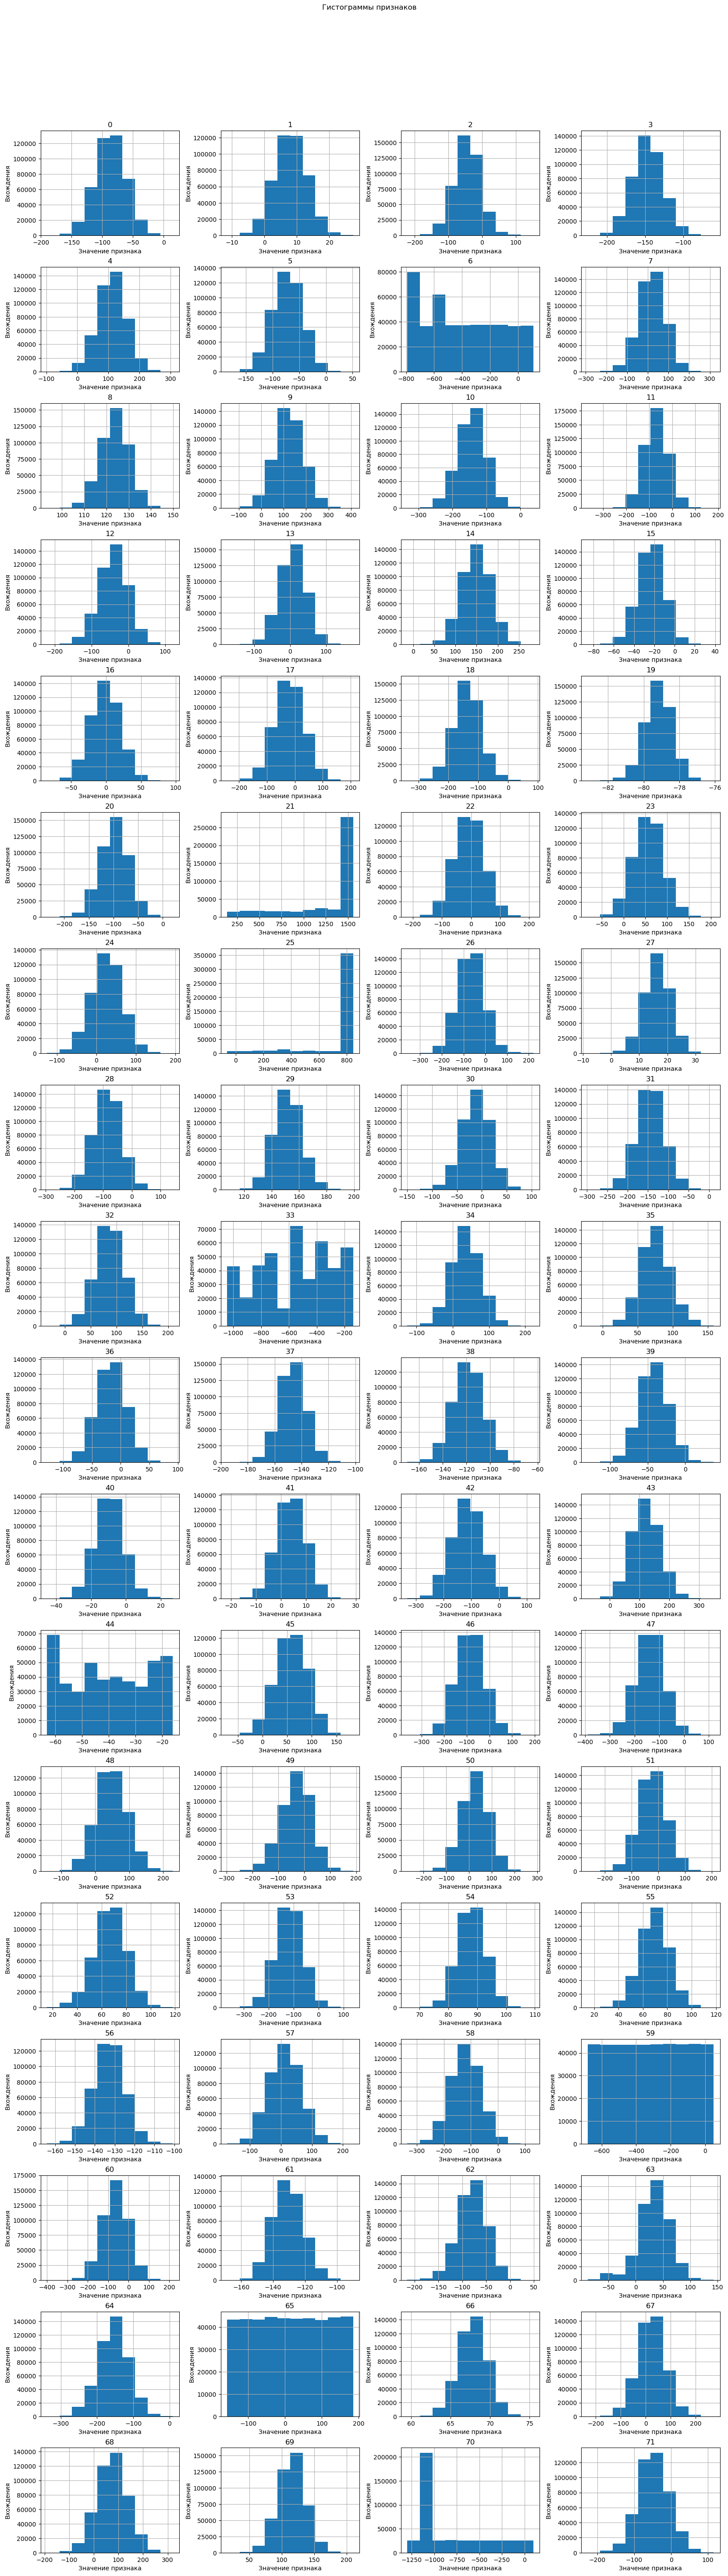

In [13]:
check_emissions(df_base_sample, df_base_sample.columns)

В основном - нормально распределение. 

Но есть несколько исключений: 6: линейное с выбросами, 21: линейное с большими выбросами, 25: линейное с большими выбросами, 33: непонятное распределение с выбросами, 44: непонятное распределение с выбросами, 59: линейное без выбросов (категориальный признак?), 65: линейное без выбросов (категориальный?), 70: линейное с выбросами

In [14]:
#Проще всего эти признаки исключить. Но можно попробовать их так или иначе вернуть в анализ
non_normal_distribution = ['6', '21', '25', '33', '44', '59', '65', '70']

Хотя по масштабу признаки и близки друг к другу, но, тем не менее, потребуется масштабирование. Алгоритм масштабирования можно будет выбрать через тестирование разных вариантов

## Обучение моделей

### Подбор количества кластеров

Модели будут строиться с помощью faiss, которая для кластеризации использует KMeans. Чтобы примерно подобрать оптимальное количество кластеров, можно попробовать перебирать их с помощью самого алгоритма KMeans.

In [15]:
def evaluate_clasters_count(df, count):
    cluster = KMeans(n_clusters=count, init='k-means++', n_init=1,  random_state=random_seed)
    cluster.fit(df)
    return cluster.inertia_

In [16]:
df_base_normalized = df_base.drop(non_normal_distribution, axis=1)
scaler = StandardScaler().fit(df_base_normalized)
sample = df_base_normalized.sample(frac=0.15, random_state=random_seed)
sample = scaler.transform(sample)
sample.shape

(437721, 64)

In [17]:
%%time

claster_counts = [10, 50, 100, 200, 400, 800, 1000]
claster_evaluation = [evaluate_clasters_count(sample, cluster_count) for cluster_count in claster_counts]

Wall time: 20min 46s


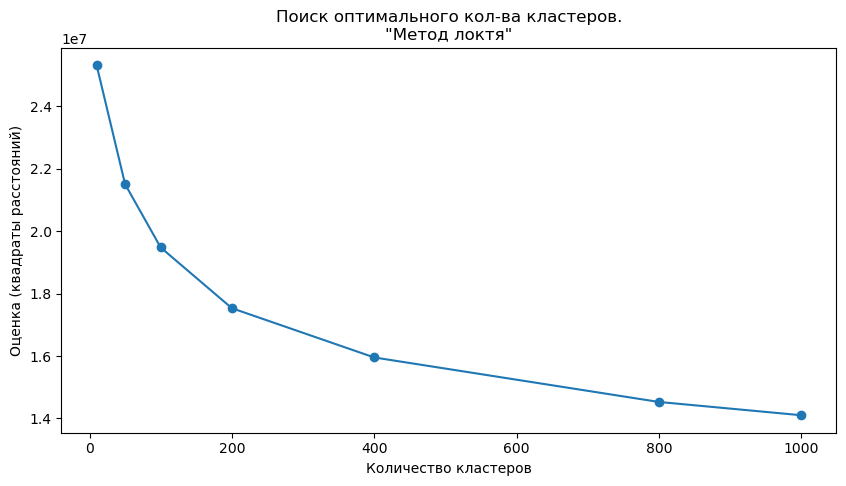

In [18]:
plt.figure(figsize=(10, 5))
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка (квадраты расстояний)')
plt.plot(claster_counts, claster_evaluation, 'o-')
plt.title('Поиск оптимального кол-ва кластеров.\n"Метод локтя"')
plt.show();

Начиная с 200 кластеров, показатель начинает выходить на плато и после 400 меняется не сильно. Можно ограничиться двумя сотнями кластеров

### Выбор модели

Для поиска ближайших соседей хорошо подходит библиотека Faiss. Остается выбрать конкретную модель. Помимо этого, при переборе моделей следует протестировать разные алгоритмы масштабирования признаков. Для всего этого подойдут пайплайны.

In [19]:
class DropNonNormal(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(non_normal_distribution, axis=1, inplace=False)

In [20]:
class AsContiguousArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.ascontiguousarray(X)
    
class FaissMipMetric(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_size):
        self.cluster_size = cluster_size
        return
    def fit(self, X, y=None):
        dimensions = X.shape[1]
        quantizer = faiss.IndexFlatL2(dimensions)        
        self.index = faiss.IndexIVFFlat(quantizer, dimensions, self.cluster_size, faiss.METRIC_INNER_PRODUCT)
        
        gc.collect()
        return self
    def transform(self, X):
        return (X, self.index)

class FaissEuclideanMetric(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_size):
        self.cluster_size = cluster_size
        return
    def fit(self, X, y=None):
        dimensions = X.shape[1]
        quantizer = faiss.IndexFlatL2(dimensions)        
        self.index = faiss.IndexIVFFlat(quantizer, dimensions, self.cluster_size)
        gc.collect()
        return self
    def transform(self, X):
        return (X, self.index)
    
class FaissCosinMetric(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_size):
        self.cluster_size = cluster_size
        return
    def fit(self, X, y=None):
        dimensions = X.shape[1]
        quantizer = faiss.IndexFlatL2(dimensions)
        self.index = faiss.IndexIVFFlat(quantizer, dimensions, self.cluster_size, faiss.METRIC_INNER_PRODUCT)   
        gc.collect()
        return self
    def transform(self, X):
        faiss.normalize_L2(X)
        return (X, self.index)

class FaissFlatIdx(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        df, index = X        
        index.train(df[:400000])
        index.add(df)
        return self
    def transform(self, X):
        return X;
    
class FaissHnswIdx(BaseEstimator, TransformerMixin):
    def __init__(self, ef_search=32):
        self.ef_search = ef_search
        return
    def fit(self, X, y=None):
        dimensions = X.shape[1]        
        self.index = faiss.index_factory(dimensions, (f'HNSW{self.ef_search},Flat'))
        self.index.nprobe = 8
                
        self.index.train(X[:400000])
        self.index.add(X)
        gc.collect()
        return self
    def transform(self, X):
        return (X, self.index);
    
class FaissIvfHnswIdx(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_size, ef_search=32):
        self.ef_search = ef_search
        self.cluster_size = cluster_size
        return
    def fit(self, X, y=None):
        dimensions = X.shape[1]        
        self.index = faiss.index_factory(dimensions, (f'IVF{self.cluster_size}_HNSW{self.ef_search},Flat'))
        self.index.nprobe = 8
                
        self.index.train(X[:400000])
        self.index.add(X)
        gc.collect()
        return self
    def transform(self, X):
        return (X, self.index);
    
class FaissSearch(BaseEstimator, TransformerMixin):
    def __init__(self, target_count):
        self.target_count = target_count
        return
    def fit(self, X, y=None):
        self.is_fitted = False
        return self
    def transform(self, X):
        if (not self.is_fitted):
            self.is_fitted = True
            return X
        df, index = X
        return index.search(df, self.target_count)    

base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
class SearchEvaluate(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self
    def score(self, X, y=None):
        r, idx = X
        
        acc = 0
        for target, el in zip(y.values.tolist(), idx.tolist()):
            acc += int(target in [base_index[r] for r in el])
        
        return (100 * acc / len(idx))
    def transform(self, X):  
        return X;

In [51]:
drop_non_normal = ('Drop non normal', DropNonNormal())
as_contiguous_array = ('Convert to contiguous array', AsContiguousArray())
scaler_pipes = [
    [drop_non_normal, as_contiguous_array],
    [drop_non_normal, ('Standard scaler', StandardScaler()), as_contiguous_array],
    [drop_non_normal, ('Robust scaler', RobustScaler()), as_contiguous_array]
]
faiss_flat = ('Flat faiss index', FaissFlatIdx())
faiss_pipes = [
    [('Euclidean metric', FaissEuclideanMetric(200)), faiss_flat],
    [('Mip metric', FaissMipMetric(200)), faiss_flat],
    [('Cosin metric', FaissCosinMetric(200)), faiss_flat],
    [('Ivf+Hnsw', FaissIvfHnswIdx(200))],
    [('Hnsw', FaissHnswIdx())]
]
evaluation_pipe = [
    ('Search of 5 closest', FaissSearch(5)), 
    ('Evaluate search', SearchEvaluate())
]

pipes = []
for scaler_pipe in scaler_pipes:
    for faiss_pipe in faiss_pipes:
        pipes.append(Pipeline(scaler_pipe + faiss_pipe + evaluation_pipe))
        
gc.collect()

57

In [54]:
pipes_results = []
current_idx = 0

for pipe in pipes:
    start_time = time.time()
    pipe.fit(df_base)
    fit_duration = time.time() - start_time
    
    start_time = time.time()
    score = pipe.score(df_train, df_train_target)
    evaluation_duration = time.time() - start_time
    
    pipes_results.append([pipe, score, process.memory_info().rss, fit_duration, evaluation_duration])
    
    current_idx += 1
    print('Обработано:', current_idx, 'из', len(pipes))

Обработано: 1 из 15
Обработано: 2 из 15
Обработано: 3 из 15
Обработано: 4 из 15
Обработано: 5 из 15
Обработано: 6 из 15
Обработано: 7 из 15
Обработано: 8 из 15
Обработано: 9 из 15
Обработано: 10 из 15
Обработано: 11 из 15
Обработано: 12 из 15
Обработано: 13 из 15
Обработано: 14 из 15
Обработано: 15 из 15


In [55]:
evaluation_result = pd.DataFrame(pipes_results, columns=['Pipe', 'Score, %', 'Memory, bytes', 'Fit duration, s.', 'Evaluation duration, s.']).sort_values(['Score, %'], ascending=False)
evaluation_result.style

,Pipe,"Score, %","Memory, bytes","Fit duration, s.","Evaluation duration, s."
13,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Robust scaler', RobustScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Ivf+Hnsw', FaissIvfHnswIdx(cluster_size=200)), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",69.778000,3120529408,21.129472,207.767205
8,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Standard scaler', StandardScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Ivf+Hnsw', FaissIvfHnswIdx(cluster_size=200)), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",69.719000,2977329152,12.613930,202.596431
3,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Convert to contiguous array', AsContiguousArray()), ('Ivf+Hnsw', FaissIvfHnswIdx(cluster_size=200)), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",68.381000,1817604096,16.513700,187.864159
12,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Robust scaler', RobustScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Cosin metric', FaissCosinMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",62.919000,3112947712,17.794379,24.653329
7,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Standard scaler', StandardScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Cosin metric', FaissCosinMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",62.863000,2457534464,13.207145,19.654016
5,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Standard scaler', StandardScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Euclidean metric', FaissEuclideanMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",62.648000,2399444992,15.396404,26.443871
10,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Robust scaler', RobustScaler()), ('Convert to contiguous array', AsContiguousArray()), ('Euclidean metric', FaissEuclideanMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",62.639000,3645583360,20.677134,30.387660
4,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Convert to contiguous array', AsContiguousArray()), ('Hnsw', FaissHnswIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",60.948000,2253492224,334.194844,6.854693
0,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Convert to contiguous array', AsContiguousArray()), ('Euclidean metric', FaissEuclideanMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",60.327000,2188709888,8.821984,25.488362
2,"Pipeline(steps=[('Drop non normal', DropNonNormal()), ('Convert to contiguous array', AsContiguousArray()), ('Cosin metric', FaissCosinMetric(cluster_size=200)), ('Flat faiss index', FaissFlatIdx()), ('Search of 5 closest', FaissSearch(target_count=5)), ('Evaluate search', SearchEvaluate())])",60.210000,3683028992,7.470244,24.432466


In [57]:
set_config(display="diagram")

best_pipe = evaluation_result.head(1)
print(f'Оценка лучшего pipeline: {best_pipe["Score, %"].values[0]}%')
print('Лучший pipeline: ')
best_pipe['Pipe'].values[0]

Оценка лучшего pipeline: 69.778%
Лучший pipeline: 


Pipeline(steps=[('Drop non normal', DropNonNormal()),
                ('Robust scaler', RobustScaler()),
                ('Convert to contiguous array', AsContiguousArray()),
                ('Ivf+Hnsw', FaissIvfHnswIdx(cluster_size=200)),
                ('Search of 5 closest', FaissSearch(target_count=5)),
                ('Evaluate search', SearchEvaluate())])

С точки зрения качества оценки, лучший результат выдает индексация Faiss Ifv+Hnsw. Однако, при наличии высоких требований к скорости работы модели, этот вариант может не подойти - плоский Faiss гораздо производительнее. А Faiss по графу Hnsw без кластеризации дает самые быстрые ответы с самым медленным обучением и посредственной оценкой в районе 58%.

## Валидация финальной модели

In [58]:
score = best_pipe['Pipe'].values[0].fit(df_base).score(df_valid, df_valid_target['Expected'])
print(f'Оценка на валидационных данных: {score}%')

Оценка на валидационных данных: 69.627%


Оценка на валидационной выборке примерно соответствует оценке на обучающей выборке

## Итоги

* В данных присутствуют признаки с ненормальным распределением - их потребовалось удалить из векторов перед передачей в Faiss. Кроме того, небольшое увеличение точности было получено за счет масштабирования признаков.
* Анализ количества кластеров с кластеризацией по алгоритму KMeans, показал, что оптимальное значение находится в районе 200. Это количесто и использовалось при переборе моделей.
* Максимальную точность из исследованных алгоритмов выдает **Faiss** на комбинации **Ivf+Hnsw**.
* Самую высокую скорость поиска выдает Faiss на графе Hnsw. Однако, его точность и скорость обучения не высоки. Возможно, увеличение количества связей на вектор может увеличить точность за счет еще большей ресурсоемкости.